In [10]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

os.chdir("..")

from util.munge import max_print, format_date
from util.data_mappings import state_full_names


warnings.filterwarnings('ignore')
matplotlib.style.use("fivethirtyeight")

In [11]:
def get_covid_tracking_daily_df():
    states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
    states["state"] = states["state"].map(state_full_names)
    states = states.sort_values(["state","date"]).reset_index()
    return states

In [12]:
daily = get_covid_tracking_daily_df()
daily.date.max()

20200413

In [13]:
odd_day = True
if int(daily.date.max()) % 2 == 0:
    odd_day = False

In [14]:
# daily data is prone to misreported numbers or errors
# we can smooth the reported positives by looking at 
# positive case growth every 2 days
daily["positiveIncreaseLag"] = daily.groupby("state")["positiveIncrease"].shift(1)
daily["twoDayPositiveIncrease"] = daily["positiveIncrease"] + daily["positiveIncreaseLag"]
if odd_day:
    smoothed_daily = daily.loc[~(daily["date"] % 2 == 0)]
else:
    smoothed_daily = daily.loc[daily["date"] % 2 == 0]
    
smoothed_daily = daily
# plot drop off
smoothed_daily["logPositiveNew"] = np.log(smoothed_daily["twoDayPositiveIncrease"])
smoothed_daily["logPositiveTotal"] = np.log(smoothed_daily["positive"])
smoothed_daily["logPositiveOld"] = np.log(smoothed_daily["positive"] - smoothed_daily["twoDayPositiveIncrease"])


In [16]:
# spot check California
smoothed_daily.loc[daily["state"] == "California"][[
    "date", "twoDayPositiveIncrease", "positive"]]

,date,twoDayPositiveIncrease,positive
186,20200304,NaN,53.0
187,20200305,NaN,53.0
188,20200306,7.0,60.0
189,20200307,16.0,69.0
190,20200308,28.0,88.0
191,20200309,45.0,114.0
192,20200310,45.0,133.0
193,20200311,43.0,157.0
194,20200312,69.0,202.0
195,20200313,45.0,202.0


In [17]:
# plot variables and settings
latest_update = format_date(str(smoothed_daily["date"].max()))
states = ["New York", "New Jersey", "Washington", "California", "Louisiana"]
to_plot = smoothed_daily.loc[daily["state"].isin(states)]

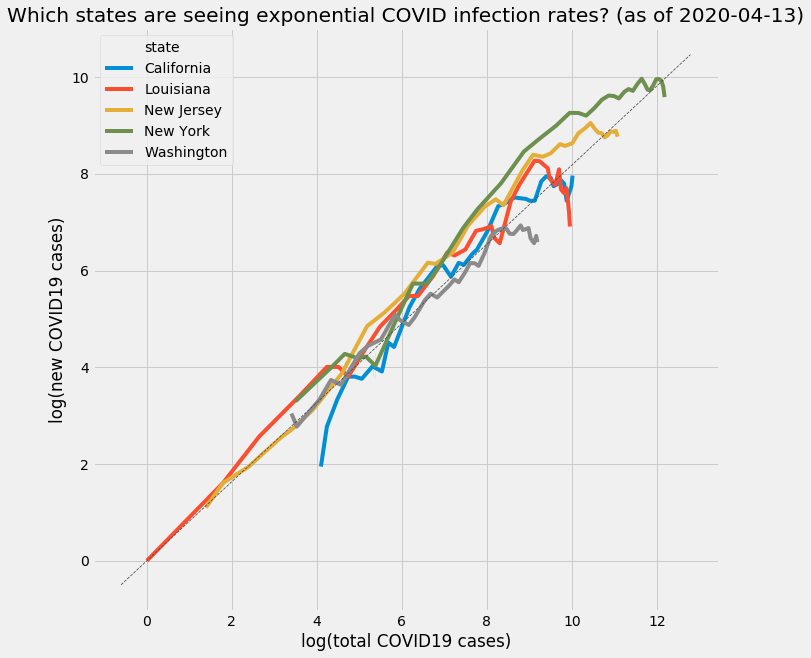

In [18]:
# log-log plot of growth rate v total (positives)
plt.figure(figsize=(10,10))
ax = sns.lineplot(
    x="logPositiveTotal",
    y="logPositiveNew",
    hue="state",
    data=to_plot
)

ax.set(
    xlabel="log(total COVID19 cases)",
    ylabel="log(new COVID19 cases)",
    title=f"Which states are seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()

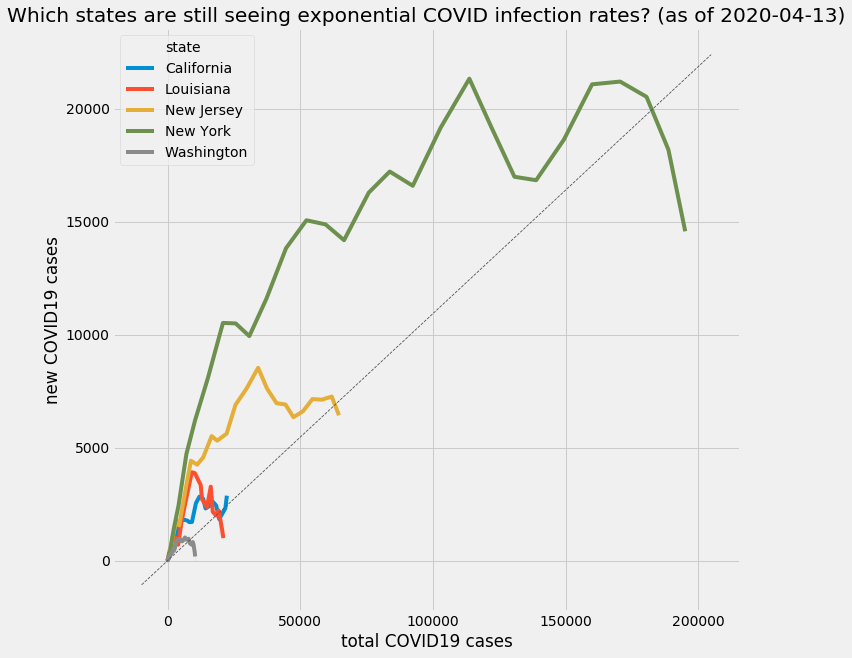

In [19]:
# linear-scale plot of growth rate v total (positives)
plt.figure(figsize=(10,10))
ax = sns.lineplot(
    x="positive",
    y="twoDayPositiveIncrease",
    hue="state",
    data=to_plot
)

ax.set(
    xlabel="total COVID19 cases",
    ylabel="new COVID19 cases",
    title=f"Which states are still seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()